## Abstract

In scenarios of low power production in windfarms, due to abrupt wind variations, reserve power is immediately activated. However, energy distribution from secondary sources can experience delays. Short-term power predictions derived from monitored wind turbines become useful to address such circumstances: while meteorological models are computationally intense, data-science models obtain faster and more accurate results for short-term periods (e.g., 3-6 hours). In this study, raw data from 4 monitored wind turbines has been combined with meteorological information from a weather station located 35 Km away from the windfarm. Feature engineering led to creation of: (1) 30 new time variables and (2) our target; the mean power of the next 3 hours. Four models are proposed in this study to successfully predict the power output, being the runtime of each model a key matter for near-term predictions. Modelling with a single turbine offers the most efficient results: accurate predictions, low MAE (~ 8%) and fast runtime (less than 10 minutes).


## Table of Contents:

* [0. Dataset description](#s0)
* [1. Load Windfarm's data](#s1)
    * [1.1 Preliminary analysis](#s1.1)
    * [1.2 Concatenate windfarm dataframes](#s1.2)
* [2. Preprocessing](#s2)
    * [2.1 Deletion of features with high NaN %](#s2.1)
    * [2.2 Feature cleansing](#s2.2)
    * [2.3 Create 1 dataframe per turbine](#s2.3)
    * [2.4 Visualization of windfarm's data](#s2.4)
* [3. Meteorological Data (independent station): processing](#s3)
* [4. Feature Engineering](#s4)
    * [4.1 Time variables creation](#s4.1)
    * [4.2 Create the target: P_3h](#s4.2)
    * [4.3 Merge turbines with meteo](#s4.3)
    * [4.4 Interpolate missing meteorological records](#s4.4)
* [5. Work with all data: turbines + meteo](#s5)
    * [5.1 Concatenate all turbines with meteo](#s5.1)
    * [5.2 Processing all data](#s5.1)
    * [5.3 Create variables from months and years](#s53)
* [6. Correlation matrix between all features](#s6)
* [7. Windrose graphs](#s7)
* [8. Last processing before modelling](#s8)
    * [8.1 Check for infinites and substitute](#s8.1)
    * [8.2 Create dataframe from a single turbine](#s8.2)
    * [8.3 Remove outliers with IQR](#s8.3)
    * [8.4 Extract the target and save it as CSV](#s8.4)
    * [8.5 Standarize](#s8.5)
    * [8.6 NaN imputation: KNNimputer](#s8.6)
    * [8.7 Export data for modelling as CSV](#s8.7)



### 0) Dataset description: <a class="anchor" id="s0"></a>

**0.1 Windfarm's data:**

    - 1 dataset from 2013 to 2016; data recorded every 10 min. 
    - 1 dataset from 2017 to January 2018; data recorded every 10 min.
    - link: 
   https://opendata-renewables.engie.com/explore/index

**0.2 Meteorological station's data:**

    - 1 dataset from 2013 to January 2018; data recorder every 3 hrs.
    - link: 
   https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/export/?refine.nom_reg=Grand+Est&refine.libgeo=Thuilley-aux-Groseilles&q.timerange.date=date:%5B2012-12-31T23:00:00Z+TO+2018-01-13T22:59:59Z%5D



In [3]:
# Import Libraries

# Basics
import pandas as pd
import numpy as np
from datetime import datetime


# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from windrose import WindroseAxes


# Preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

### 1) Load Windfarm's data <a class="anchor" id="s1"></a>
   - 1.1 Preliminary analysis 
   - 1.2 Concatenate windfarm dataframes 

In [4]:
# Load windfarm's data:

# Dataset 1: windfarm's data between 2013 and 2016
df_13_16= pd.read_csv('la-haute-borne-data-2013-2016.csv', delimiter= ';')

# Dataset 2: windfarm's data between 2017 and 2018
df_17_18= pd.read_csv('la-haute-borne-data-2017-2020.csv', delimiter= ';')

**1.1 Preliminary analysis** <a class="anchor" id="s1.1"></a>

In [5]:
# Head of df_13_16; 138 columns are displayed
pd.set_option('display.max_columns', None)
df_13_16.head()

Wind_turbine_name                  Date_time     Ba_avg     Ba_min  \
0            R80711  2013-01-07T01:20:00+01:00  41.160000  -1.000000   
1            R80711  2013-01-05T22:20:00+01:00  -1.000000  -1.000000   
2            R80711  2013-01-06T08:30:00+01:00  -1.000000  -1.000000   
3            R80711  2013-01-05T21:10:00+01:00  44.990002  44.990002   
4            R80711  2013-01-06T11:20:00+01:00  -0.760000  -1.000000   

      Ba_max  Ba_std  Rt_avg  Rt_min  Rt_max  Rt_std     DCs_avg     DCs_min  \
0  44.990002   11.27   12.65    12.0    13.0    0.41   204.71001  125.760000   
1  -0.870000    0.01   12.95    12.0    13.0    0.16  1157.03000  968.130000   
2  -1.000000    0.00   13.74    13.0    14.0    0.35  1021.18000  970.070010   
3  44.990002    0.00   12.14    12.0    13.0    0.27   122.29000   79.279999   
4   0.000000    0.40   13.78    13.0    14.0    0.35  1041.27000  960.599980   

      DCs_max     DCs_std   Cm_avg     Cm_min     Cm_max     Cm_std  \
0   987.83002  140.620000    -6.15   -6.39000    -5.8900    0.08000   
1  1370.16000  106.870000  1556.76  834.54999  2278.9399  344.91000   
2  1090.63000   34.230000  1142.24  759.06000  1384.6300  120.20000   
3   175.20000   22.840000    -6.09   -6.42000    -5.8600    0.09000   
4  1157.36000   64.559998  1052.10  249.23000  1557.4200  374.07001   

        P_avg      P_min   P_max      P_std      Q_avg  Q_min       Q_max  \
0   -1.380000  -5.620000   -0.70   0.890000   0.000000  -0.79    0.130000   
1  161.860000  47.680000  301.62  60.209999  20.170000  10.61   25.120001   
2   91.400002  47.220001  125.49  16.010000  22.740000  12.86   29.740000   
3   -0.920000  -1.410000   -0.58   0.130000   0.000000  -0.19    0.100000   
4   87.900002   0.780000  159.72  46.110001  75.080002  21.92  109.340000   

       Q_std   S_avg      S_min      S_max      S_std  Cosphi_avg  Cosphi_min  \
0   0.030000    1.38   0.700000    5.62000   0.890000        1.00        1.00   
1   2.970000  163.41  50.060001  302.07999  59.549999        0.99        1.00   
2   2.390000   94.32  52.430000  127.89000  15.540000        0.96        0.99   
3   0.010000    0.92   0.580000    1.41000   0.130000        1.00        1.00   
4  32.619999  124.47  39.889999  183.75000  32.650002        0.77        1.00   

   Cosphi_max  Cosphi_std   Ds_avg      Ds_min      Ds_max      Ds_std  \
0        1.00        0.00   202.28  123.620000   985.67999  140.580000   
1        0.91        0.02  1155.52  966.429990  1368.72000  106.940000   
2        0.91        0.01  1019.75  968.700010  1089.18990   34.250000   
3        1.00        0.00   119.91   76.730003   172.60001   22.820000   
4        0.03        0.28  1039.77  959.049990  1155.93990   64.589996   

    Db1t_avg   Db1t_min   Db1t_max  Db1t_std   Db2t_avg   Db2t_min   Db2t_max  \
0  28.330000  28.000000  28.500000      0.10  25.990000  25.799999  26.200001   
1  29.580000  28.900000  30.299999      0.33  28.090000  27.500000  28.700001   
2  42.520000  41.750000  43.200001      0.36  41.549999  40.900002  42.000000   
3  29.049999  28.900000  29.200001      0.05  26.280001  26.100000  26.400000   
4  44.320000  43.599998  44.849998      0.24  43.430000  43.000000  43.799999   

   Db2t_std    Dst_avg    Dst_min    Dst_max  Dst_std   Gb1t_avg   Gb1t_min  \
0      0.12  32.580002  32.049999  32.950001     0.20  36.950001  36.750000   
1      0.34  42.130001  40.450001  43.650002     0.69  53.970001  53.200001   
2      0.28  64.589996  63.150002  66.150002     0.52  53.660000  53.299999   
3      0.10  32.990002  32.700001  33.400002     0.15  39.470001  39.400002   
4      0.18  64.919998  63.400002  66.000000     0.48  56.849998  56.250000   

    Gb1t_max  Gb1t_std   Gb2t_avg   Gb2t_min   Gb2t_max  Gb2t_std    Git_avg  \
0  37.200001      0.08  37.110001  37.099998  37.200001      0.02  37.779999   
1  54.650002      0.37  53.459999  52.599998  54.099998      0.50  43.459999   
2  54.099998      0.16  51.779999  51.299999  52.299999      0.2

In [6]:
# Checking shapes of windfarm's dataframes:

print('Shape 2013-2016:', df_13_16.shape)
print('Shape 2017-2018:', df_17_18.shape)

Shape 2013-2016: (840380, 138)
Shape 2017-2018: (217588, 138)


In [7]:
# Checking the number of wind turbines and number records/turbine:
df_13_16['Wind_turbine_name'].value_counts() # 4 turbines; 2013 - 2016

R80790    210095
R80721    210095
R80711    210095
R80736    210095
Name: Wind_turbine_name, dtype: int64

In [8]:
# Checking the number of wind turbines and number records/turbine:
df_17_18['Wind_turbine_name'].value_counts() # 4 turbines 2017-2018

R80721    54433
R80711    54433
R80736    54433
R80790    54289
Name: Wind_turbine_name, dtype: int64

**1.2 Concat windfarm dataframes** <a class="anchor" id="s1.2"></a>

In [9]:
frames = [df_13_16, df_17_18] 
df_turb = pd.concat(frames) # concat df_13_16 & df_17_18

print('Shape of windfarm dataframe:', df_turb.shape)  # result shape

Shape of windfarm dataframe: (1057968, 138)


In [10]:
# Delete df_13_16 & df_17_18
del df_13_16
del df_17_18

In [11]:
# Sort dataframe by datetime and reset index:
df_turb= df_turb.sort_values('Date_time')
df_turb= df_turb.reset_index()

### 2) Preprocessing <a class="anchor" id="s2"></a>
   - 2.1 Deletion of features with high NaN % 
   - 2.2 Feature cleansing 
   - 2.3 Create 1 dataframe per turbine 
   - 2.4 Visualization of windfarm's data 

**2.1 Deletion of features with high NaN %** <a class="anchor" id="s2.1"></a>

In [12]:
# Calculate % of NaN
nulls= df_turb.isnull().sum()/len(df_turb)*100

In [13]:
# Display columns and NaN %
nulls

index                  0.000000
Wind_turbine_name      0.000000
Date_time              0.000000
Ba_avg                 0.626673
Ba_min                 0.626673
                        ...    
Wa_c_std             100.000000
Na_c_avg              20.586350
Na_c_min             100.000000
Na_c_max             100.000000
Na_c_std             100.000000
Length: 139, dtype: float64

In [14]:
# Append on a list features/columns with NaN ≥ 20%

columns_high_NaN= []   # list

for column, NaN in zip(df_turb.columns, nulls): # iterate through columns and % NaN
    if NaN >= 20:  
        columns_high_NaN.append(column) # appends column name if NaN >= 20

In [15]:
# Drop columns with NaN ≥ 20% from list of column names 
df_turb= df_turb.drop(columns_high_NaN, axis=1)

**2.2 Feature cleansing** <a class="anchor" id="s2.2"></a>
        
    - The correlation matrix has been used to delete features that (1) show excessive correlation between each others, (2) are too correlataed with P (power) and (3) their correlation is too low with the P. 
       
    - This process has been carried out with previous understanding of the significance each from feature

**Find all heatmaps in: Jupyter Notebooks/ Heatmaps.pdf**

In [16]:
# Heatmap with correlation matrix from all windfarm's features; not executed

sns.set(rc={'figure.figsize':(100,100)}) 
sns.heatmap(df_turb.corr(), annot = True, cmap = "Blues")

In [17]:
# Drop columns non-correlated with the target (P)
df_turb= df_turb.drop(['Rbt_std', 'Rs_std', 'Nu_std',
                     'Nf_std',   'Nf_min',  'Nf_max', 'Nf_avg',
                     'Va_std',   'Va_min',  'Va_max', 'Va_avg',
                     'Wa_std',   'Wa_min',  'Ya_avg', 'Ya_min',
                     'Ya_max',   'Gost_std','Git_std','Gb1t_std',
                     'Gb2t_std', 'Db2t_std','Db2t_min','Db2t_max',
                     'Db2t_avg', 'Db1t_std','Db1t_min','Db1t_max',
                     'Db1t_avg', 'Cosphi_std','Cosphi_min','Cosphi_max',
                     'Cosphi_avg','DCs_std', 'Rt_std', 'Rt_min', 
                     'Rt_max', 'Rt_avg', 'Ba_std'], axis = 1)

In [18]:
# Drop columns that have excessive correlation (aprox 1 and -1) with another feature
df_turb= df_turb.drop(['Wa_max', 'Nu_max', 'Nu_min', 'Nu_avg', 'Ya_std',
                     'Ds_std', 'Rm_std', 'Rm_avg', 'Rm_max', 'Rm_min',
                     'DCs_avg', 'DCs_max', 'DCs_min', 'Ds_avg', 'Ds_max',
                     'Ds_min', 'Gb1t_max', 'Gb1t_min', 'Gb2t_min', 'Gb2t_max',
                     'Dst_max', 'S_max', 'S_min', 'S_std', 'S_avg', 'Cm_max',
                     'Cm_min', 'Cm_std', 'Cm_avg', 'Dst_std'], axis = 1)

**2.3 Create 1 dataframe per turbine** <a class="anchor" id="s2.3"></a>

    - goal: concat with meteorological data each generator's dataframe
    - fill missing values with interpolate()


In [19]:
# Function to clean 'Date_time' format
def clean_date(string):
    return " ".join(string.split("+")[0].split("T")) 

In [20]:
# Clean "Date_time"
df_turb["Date_time"] = df_turb["Date_time"].apply(clean_date)

In [21]:
# Create a dictionary of dataframes with 'Wind_turbine_name' as keys
dict_frames = dict(tuple(df_turb.groupby('Wind_turbine_name')))

# Save each dataframe within a new variable name
df_turb11 = dict_frames['R80711']
df_turb21 = dict_frames['R80721']
df_turb36 = dict_frames['R80736']
df_turb90 = dict_frames['R80790']

In [22]:
del dict_frames # del dictionary to save some space

**2.4 Visualization of windfarm's data** <a class="anchor" id="s2.4"></a>

In [23]:
# Power vs Wind Speed. 4 turbines, each one with a different color
sns.scatterplot(data=df_turb, x="Ws_avg", y="P_avg", hue="Wind_turbine_name")
sns.set(font_scale= 3)
plt.title('Wind speed vs Power. 4 generators')
sns.set(rc={'figure.figsize':(10,10)})
plt.show()

/Users/alexschaub/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


In [24]:
# Select values recorded when the machine is stopped but the anemometers still work
sel_rows=df_turb[(df_turb['P_avg']<=0) &  (df_turb['Ws_avg']> 4.6)].index # where P <= 0 and Ws_avg > 4.6

In [25]:
# Delete selected rows from df_gen
df_turb = df_turb.drop(sel_rows, axis=0)

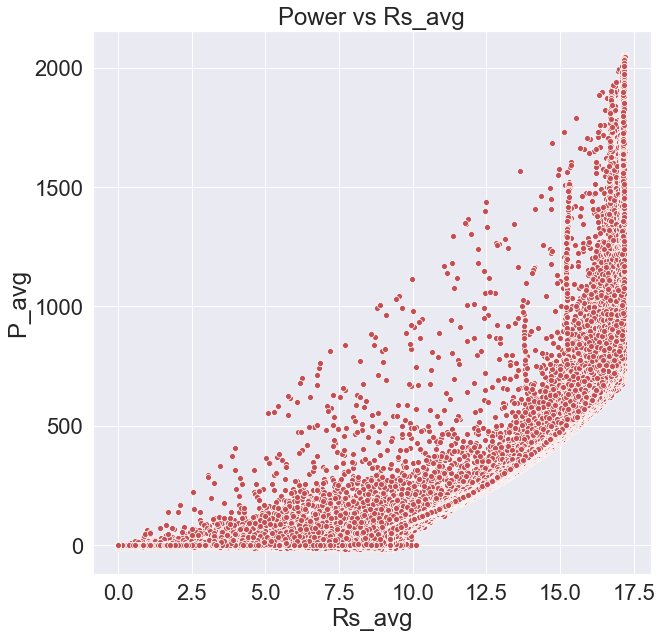

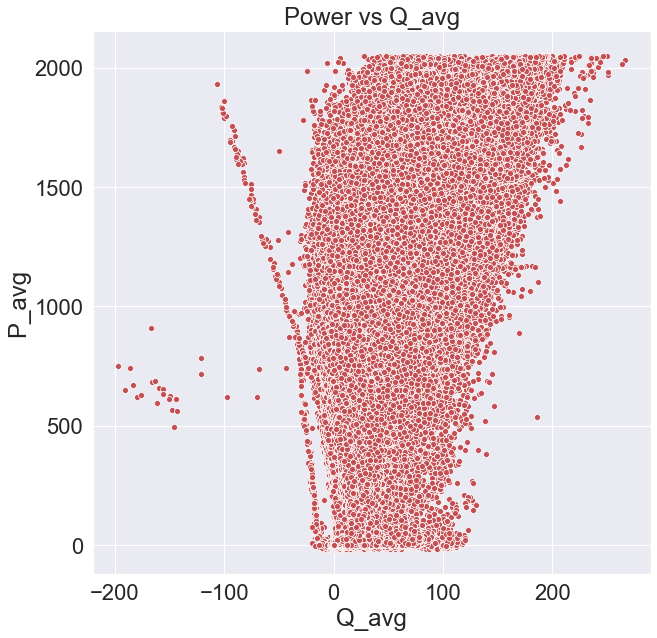

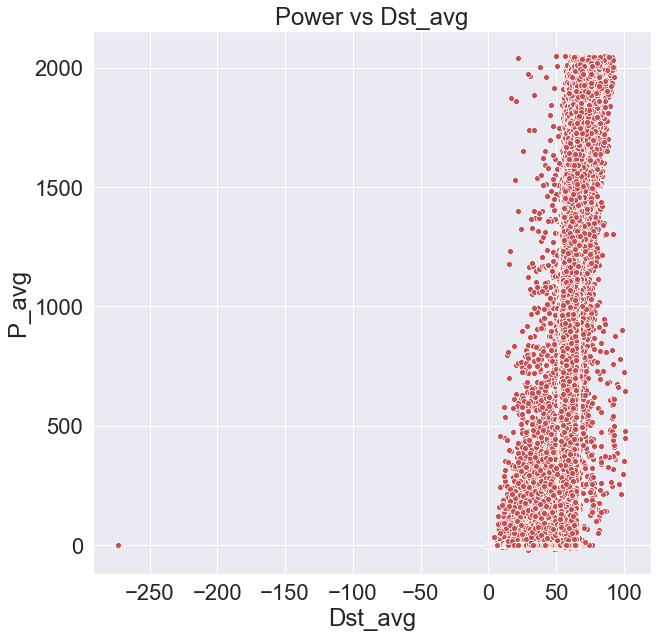

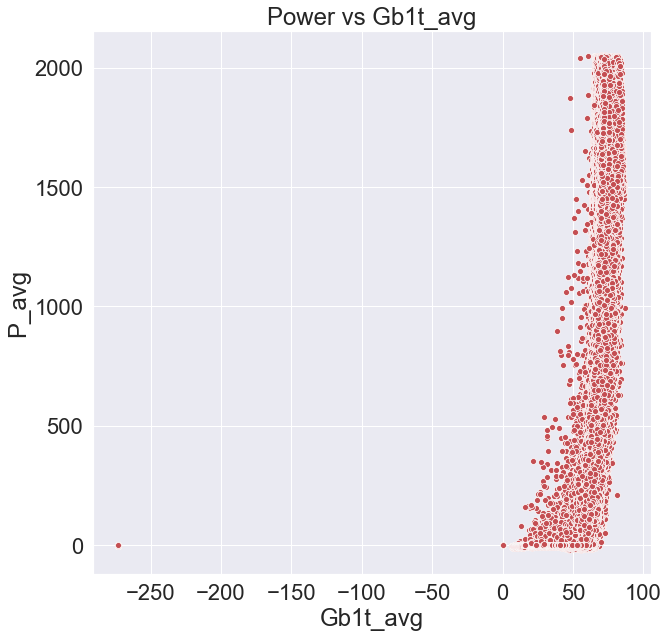

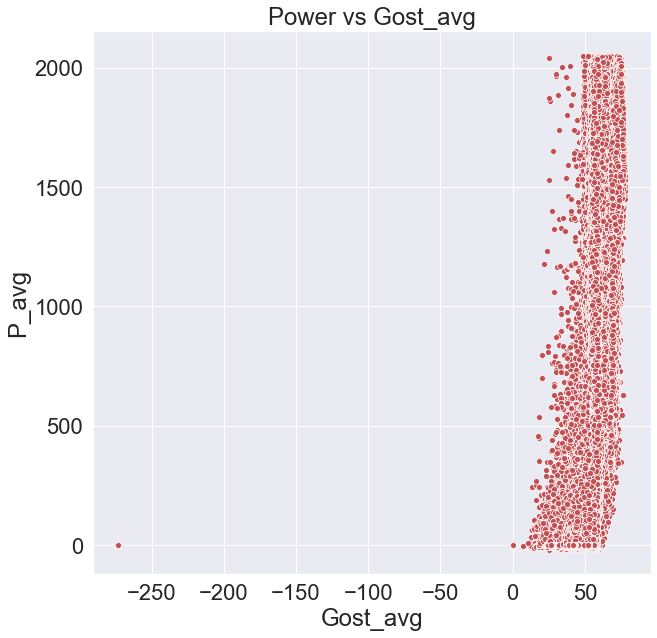

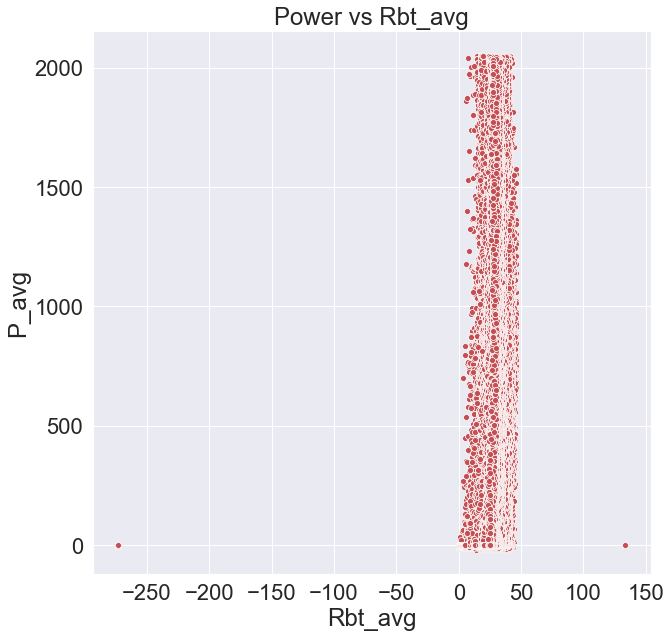

In [26]:
# Plot 'P_Avg' (power) vs rotor speed(RS), reactive power (Q_avg), stator temperature (DST), gearbox bearing temperature
# (Gb1t), gearbox oil temperature (Gost), rotor bearing temperature (Rbt)
for i in [ 'Rs_avg','Q_avg', 'Dst_avg', 'Gb1t_avg', 'Gost_avg','Rbt_avg']:
    sns.set(font_scale=2)
    sns.scatterplot(df_turb[i] ,df_turb.P_avg, color="r")
    plt.title('Power vs'+' '+i)
    sns.set(rc={'figure.figsize':(10,10)})
    plt.show()

### 3) Meteorological Data (independent station): processing <a class="anchor" id="s3"></a>

In [27]:
# Load csv with meteorological data
df_met = pd.read_csv('donnees-synop-essentielles-omm_TRUE.csv', delimiter= ';')

In [28]:
# Drop static useless data, such as city name, department etc...
df_met=df_met.drop(['Nom',          
'ID OMM station','Altitude','Longitude','Latitude',
'communes (name)','communes (code)','EPCI (name)',
'EPCI (code)','department (name)','department (code)',
'region (name)','region (code)','mois_de_l_annee','Coordonnees'], axis=1)

In [29]:
# Calculate % nulls per column
nulls_meteo= df_met.isnull().sum()/len(df_met)*100
for column, percentage in zip(df_met.columns, nulls_meteo):
    print(column, percentage)

Date 0.0
Pression au niveau mer 0.006929046563192905
Variation de pression en 3 heures 0.05543237250554324
Type de tendance barométrique 0.05543237250554324
Direction du vent moyen 10 mn 0.02771618625277162
Vitesse du vent moyen 10 mn 0.020787139689578713
Température 0.0
Point de rosée 0.0
Humidité 0.0
Visibilité horizontale 0.0
Temps présent 0.09700665188470067
Temps passé 1 62.922671840354774
Temps passé 2 63.21369179600887
Nebulosité totale 21.91657427937916
Nébulosité  des nuages de l' étage inférieur 6.042128603104214
Hauteur de la base des nuages de l'étage inférieur 22.68569844789357
Type des nuages de l'étage inférieur 57.99611973392461
Type des nuages de l'étage moyen 61.4329268292683
Type des nuages de l'étage supérieur 61.883314855875824
Pression station 0.006929046563192905
Niveau barométrique 100.0
Géopotentiel 100.0
Variation de pression en 24 heures 39.308481152993345
Température minimale sur 12 heures 75.03464523281596
Température minimale sur 24 heures 100.0
Températur

In [30]:
# Append on a list features/columns with NaN ≥ 20%

columns_high_NaN= []   # list

for column, NaN in zip(df_met.columns, nulls_meteo): # iterate through columns and % NaN
    if NaN >= 18:  
        columns_high_NaN.append(column) # appends column name if NaN >= 20

In [31]:
df_met = df_met.drop(columns_high_NaN, axis=1)

In [32]:
# Delete irrelevant or repetitive information (already present in windfarm's data)
df_met = df_met.drop(['Direction du vent moyen 10 mn', 'Vitesse du vent moyen 10 mn', 
                      'Vitesse du vent moyen 10 mn','Temps présent', 
                      'Periode de mesure de la rafale', 'Point de rosée', 'Type de tendance barométrique.1',
                      'Temps présent.1', 'Température (°C)', 'Température' ], axis=1)

In [33]:
# Function: clean date time column / erase '+'
def clean_date(string):
    return " ".join(string.split("+")[0].split("T")) 

# Clean date
df_met["Date"] = df_met["Date"].apply(clean_date)

In [34]:
# Sort values by date 
df_met=df_met.sort_values(by='Date')

In [35]:
# After deleting several columns:
df_met.head()

Date  Pression au niveau mer  \
4545   2013-01-01 01:00:00                100270.0   
13413  2013-01-01 04:00:00                100210.0   
8299   2013-01-01 07:00:00                100170.0   
7024   2013-01-01 10:00:00                100480.0   
9024   2013-01-01 13:00:00                100830.0   

       Variation de pression en 3 heures  Type de tendance barométrique  \
4545                               -80.0                            6.0   
13413                              -60.0                            6.0   
8299                               -40.0                            6.0   
7024                               310.0                            3.0   
9024                               350.0                            1.0   

       Humidité  Visibilité horizontale  \
4545         91                 15000.0   
13413        93                 30000.0   
8299         94                 15000.0   
7024         89                 40000.0   
9024         74                 40000.0   

       Nébulosité  des nuages de l' étage inférieur  Pression station  \
4545                                            8.0           99700.0   
13413                                           8.0           99640.0   
8299                                            8.0           99600.0   
7024                                            6.0           99910.0   
9024                                            4.0          100260.0   

       Rafales sur une période  Précipitations dans la dernière heure  \
4545                      15.4                                    0.6   
13413                      9.8                                    0.2   
8299                       8.7                                    0.0   
7024                      12.3                                    0.0   
9024                      11.3                                    0.0   

       Précipitations dans les 3 dernières heures  
4545                                          2.0  
13413                                         1.0  
8299                                          0.0  
7024                                          0.6  
9024                                          0.2

### 4) Feature Engineering <a class="anchor" id="s4"></a>

   - 4.1 Time variables creation 
   - 4.2 Create the target: P_3h 
   - 4.3 Merge turbines with meteo 
   - 4.4 Interpolate missing meteorological records 

**4.1 Time variables creation** <a class="anchor" id="s4.1"></a>

    - Calculate variables 6h, 3h, 1h before each time record --> rolling()
    - Calculate TI (turbulence intensity) 
   

In [36]:
# To avoid default warning when applying .rolling()
pd.options.mode.chained_assignment = None  

In [37]:
# Define function with rolling()
def rolling_function(dataframe, new_column, variable, win_size):
    dataframe[new_column]= dataframe[variable].rolling(win_size).mean()
    return dataframe[new_column]

In [38]:
# Apply rolling_function 3 times (1h, 3h, 6h) to: each df (dataframes) for 10 features (variables)
dataframes = [df_turb11, df_turb21, df_turb36, df_turb90]
variables = ['Git_avg', 'Ot_avg', 'Yt_avg', 'Rs_avg', 'Gb2t_avg',
             'Gb1t_avg', 'Gost_avg', 'Wa_avg', 'Ba_avg', 'Rbt_avg']
windows= [7, 19, 37]
names_hours= ['1h', '3h', '6h']

for dataframe in dataframes:
    for variable in variables:
        for window, name  in zip(windows, names_hours): # iterates through nº rows and names of new features

            rolling_function(dataframe, variable + '_' + name, variable, int(window))           

In [39]:
# Calculate Turbulence intensity for each turbine --> std.dev Wind speed / avg Wind speed
dataframes = [df_turb11, df_turb21, df_turb36, df_turb90]
for d in dataframes: 
    d["TI"] = d["Ws_std"]/ d["Ws_avg"]

**4.2 Create the target: P_3h** <a class="anchor" id="s4.2"></a>

In [40]:
# Calculate target (P_3h) for each generator
# Apply rolling on reverse mode to calculate P_3h (it takes 19 following rows)
dataframes = [df_turb11, df_turb21, df_turb36, df_turb90]
for d in dataframes:
    d["P_3h"] = d["P_avg"].iloc[::-1].rolling(19).mean() 
    d.P_3h= d.P_3h.shift(periods=18) # Shift/push P_3h row 19 lines on each df

In [41]:
df_turb11= df_turb11.dropna(axis=0, subset=['P_3h'])
df_turb21= df_turb21.dropna(axis=0, subset=['P_3h'])
df_turb36= df_turb36.dropna(axis=0, subset=['P_3h'])
df_turb90= df_turb90.dropna(axis=0, subset=['P_3h'])

In [42]:
# Remove 'P_avg', 'P_min', 'P_max', 'P_std' to avoid overfitting; they were used to create our target(P_3h)
dataframes = [df_turb11, df_turb21, df_turb36, df_turb90]
for d in dataframes:
    del d['P_avg']
    del d['P_min']
    del d['P_max']
    del d['P_std']

In [43]:
df_turb11.shape

(261941, 79)

In [44]:
df_turb21.head()

index Wind_turbine_name            Date_time  Ba_avg  Ba_min  Ba_max  \
75  530672            R80721  2013-01-01 03:00:00   -1.02   -1.05   -1.00   
77  491030            R80721  2013-01-01 03:10:00   -1.03   -1.06   -1.01   
83  152094            R80721  2013-01-01 03:20:00   -1.03   -1.06   -1.01   
86  217514            R80721  2013-01-01 03:30:00   -0.97   -1.04    0.06   
89  233255            R80721  2013-01-01 03:40:00   -0.76   -1.03    5.59   

         Q_avg      Q_min       Q_max  Q_std    Dst_avg    Dst_min   Gb1t_avg  \
75   60.590000  42.869999   83.949997   7.82  58.919998  57.250000  72.550003   
77   69.050003  43.200001  102.630000   9.80  60.599998  58.849998  74.570000   
83   87.169998  59.060001  127.920000  18.33  62.520000  60.549999  73.199997   
86   95.290001  66.059998  130.039990  11.84  64.339996  62.400002  72.489998   
89  111.470000  80.419998  144.100010  12.85  66.129997  64.849998  71.849998   

     Gb2t_avg    Git_avg    Git_min    Git_max   Gost_avg   Gost_min  \
75  72.790001  56.730000  55.700001  57.750000  57.169998  56.200001   
77  74.449997  56.740002  51.349998  58.750000  58.599998  57.950001   
83  73.739998  50.980000  50.099998  52.099998  57.669998  57.000000   
86  73.029999  50.459999  49.099998  51.349998  57.160000  56.849998   
89  72.830002  47.310001  45.750000  49.099998  56.209999  55.450001   

     Gost_max     Yt_avg     Yt_min     Yt_max  Yt_std   Ws1_avg  Ws1_min  \
75  58.200001  25.809999  24.299999  26.900000    0.79  7.860000     5.18   
77  59.200001  27.410000  25.700001  28.200001    0.64  7.970000     5.32   
83  58.400002  24.530001  23.900000  25.700001    0.52  8.240000     5.61   
86  57.400002  23.530001  21.400000  23.900000    0.36  8.770001     5.55   
89  57.200001  16.799999  14.700000  21.400000    1.66  9.720000     6.59   

    Ws1_max  Ws1_std  Ws2_avg  Ws2_min  Ws2_max  Ws2_std  Ws_avg  Ws_min  \
75    11.28     1.11     8.00     5.53    11.42     1.07    7.93    5.46   
77    11.10     1.10     8.13     5.35    11.26     1.13    8.05    5.48   
83    11.38     1.11     8.50     5.72    11.87     1.17    8.37    5.72   
86    13.55     1.30     9.03     5.83    12.71     1.29    8.90    5.75   
89    13.90     1.48    10.00     6.80    14.31     1.49    9.86    6.81   

    Ws_max  Ws_std     Wa_avg  Ot_avg  Ot_min  Ot_max  Ot_std  Rs_avg  \
75   11.21    1.06  179.06000    6.50    6.30     6.8    0.12   16.91   
77   10.93    1.09  175.72000    6.26    6.10     6.3    0.05   17.08   
83   11.53    1.11  172.99001    6.12    6.00     6.3    0.09   17.16   
86   13.13    1.26  173.44000    5.91    5.70     6.0    0.07   17.15   
89   13.95    1.45  173.96001    5.74    5.65     5.9    0.07   17.16   

       Rs_min     Rs_max    Rbt_avg    Rbt_min    Rbt_max  Git_avg_1h  \
75  15.210000  17.340000  26.000000  25.900000  26.200001   52.118571   
77  16.280001  17.389999  26.190001  26.000000  26.299999   52.112857   
83  16.670000  17.389999  26.209999  26.200001  26.299999   51.268571   
86  16.340000  17.480000  26.280001  26.200001  26.400000   51.250000   
89  16.809999  17.639999  26.309999  26.299999  26.400000   51.494286   

    Git_avg_3h  Git_avg_6h  Ot_avg_1h  Ot_avg_3h  Ot_avg_6h  Yt_avg_1h  \
75   49.333684         NaN   6.604286   6.448421        NaN  22.832857   
77   49.967368         NaN   6.572857   6.476842        NaN  22.768571   
83   50.178947         NaN   6.510000   6.486316        NaN  22.168571   
86   50.302631         NaN   6.408571   6.472632        NaN  22.040000   
89   50.227894         NaN   6.271429   6.436316        NaN  22.071428   

    Yt_avg_3h  Yt_avg_6h  Rs_avg_1h  Rs_avg_3h  Rs_avg_6h  Gb2t_avg_1h  \
75  21.273158        NaN  16.714286  16.874211        NaN    72.464287   
77  21.925789        NaN  16.720000  16.912105        NaN    72.588572   
83  22.162632        NaN  16.742857  16.920526        NaN    72.497143   
86  22.274211        NaN  16.781429  16.922105        NaN    72.458571   
89  21.99

**4.3 Merge turbines with meteo** <a class="anchor" id="s4.3"></a>

In [45]:
# Create common column 'datetime' in all generator frames and df_met 
dataframes = [df_turb11, df_turb21, df_turb36, df_turb90]
for d in dataframes:
    d.insert(2, 'datetime', d.Date_time) # 4 turbines
df_met.insert(2, 'datetime', df_met.Date) # meteo 

In [46]:
#Convert 'datetime' column to_datetime type
dataframes = [df_turb11, df_turb21, df_turb36, df_turb90, df_met]
for d in dataframes:
    d.datetime = pd.to_datetime(d.datetime)
    d.set_index("datetime",inplace=True) # Set 'datetime' column as index in all dataframes

In [47]:
# Merge turbine's dataframes with df_met
df_turb11= pd.merge(df_met, df_turb11, how="outer", left_index=True, right_index=True)
df_turb21= pd.merge(df_met, df_turb21, how="outer", left_index=True, right_index=True)
df_turb36= pd.merge(df_met, df_turb36, how="outer", left_index=True, right_index=True)
df_turb90= pd.merge(df_met, df_turb90, how="outer", left_index=True, right_index=True)

In [48]:
df_turb11.head(40)

Date  Pression au niveau mer  \
datetime                                                           
2013-01-01 01:00:00  2013-01-01 01:00:00                100270.0   
2013-01-01 03:00:00                  NaN                     NaN   
2013-01-01 03:10:00                  NaN                     NaN   
2013-01-01 03:20:00                  NaN                     NaN   
2013-01-01 03:30:00                  NaN                     NaN   
2013-01-01 03:40:00                  NaN                     NaN   
2013-01-01 03:50:00                  NaN                     NaN   
2013-01-01 04:00:00  2013-01-01 04:00:00                100210.0   
2013-01-01 04:10:00                  NaN                     NaN   
2013-01-01 04:20:00                  NaN                     NaN   
2013-01-01 04:30:00                  NaN                     NaN   
2013-01-01 04:40:00                  NaN                     NaN   
2013-01-01 04:50:00                  NaN                     NaN   
2013-01-01 05:00:00                  NaN                     NaN   
2013-01-01 05:10:00                  NaN                     NaN   
2013-01-01 05:20:00                  NaN                     NaN   
2013-01-01 05:30:00                  NaN                     NaN   
2013-01-01 05:40:00                  NaN                     NaN   
2013-01-01 05:50:00                  NaN                     NaN   
2013-01-01 06:00:00                  NaN                     NaN   
2013-01-01 06:10:00                  NaN                     NaN   
2013-01-01 06:20:00                  NaN                     NaN   
2013-01-01 06:30:00                  NaN                     NaN   
2013-01-01 06:40:00                  NaN                     NaN   
2013-01-01 06:50:00                  NaN                     NaN   
2013-01-01 07:00:00  2013-01-01 07:00:00                100170.0   
2013-01-01 07:10:00                  NaN                     NaN   
2013-01-01 07:20:00                  NaN                     NaN   
2013-01-01 07:30:00                  NaN                     NaN   
2013-01-01 07:40:00                  NaN                     NaN   
2013-01-01 07:50:00                  NaN                     NaN   
2013-01-01 08:00:00                  NaN                     NaN   
2013-01-01 08:10:00                  NaN                     NaN   
2013-01-01 08:20:00                  NaN                     NaN   
2013-01-01 08:30:00                  NaN                     NaN   
2013-01-01 08:40:00                  NaN                     NaN   
2013-01-01 08:50:00                  NaN                     NaN   
2013-01-01 09:00:00                  NaN                     NaN   
2013-01-01 09:10:00                  NaN                     NaN   
2013-01-01 09:20:00                  NaN                     NaN   

                     Variation de pression en 3 heures  \
datetime                                                 
2013-01-01 01:00:00                              -80.0   
2013-01-01 03:00:00                                NaN   
2013-01-01 03:10:00                                NaN   
2013-01-01 03:20:00                                NaN   
2013-01-01 03:30:00                                NaN   
2013-01-01 03:40:00                                NaN   
2013-01-01 03:50:00                                NaN   
2013-01-01 04:00:00                              -60.0   
2013-01-01 04:10:00                                NaN   
2013-01-01 04:20:00                                NaN   
2013-01-01 04:30:00                                NaN   
2013-01-01 04:40:00                                NaN   
2013-01-01 04:50:00                                NaN   
2013-01-01 05:00:00                                NaN   
2013-01-01 05:10:00                                NaN   
2013-01-01 05:20:00                                NaN   
2013-01-01 05:30:00                                NaN   
2013-01-01 05:40:00                                NaN   
2013-01-01 05:50:00

**4.4 Interpolate missing meteorological records.** <a class="anchor" id="s4.4"></a>

In [49]:
# List of frames and columns to interpolate
d_frame= [df_turb11, df_turb21, df_turb36, df_turb90]
c_columns= ["Pression au niveau mer", "Variation de pression en 3 heures", "Humidité", 
         "Visibilité horizontale", "Pression station", "Rafales sur une période", 
         "Précipitations dans la dernière heure", "Précipitations dans les 3 dernières heures"]

# Interpolation of quantitative columns from df_met
for d in d_frame:
    for c in c_columns:
        d[c]= d[c].interpolate()

### 5) Work with all data: turbines + meteo <a class="anchor" id="s5"></a>

    - 5.1 Concatenate all turbines with meteo
    - 5.2 Processing all data
    - 5.3 Create variables from months and years

**5.1 Concatenate all turbines with meteo** <a class="anchor" id="s5.1"></a>

In [50]:
# Concatenate 3 dataframes without duplicates
df_4turb= pd.concat([df_turb11, df_turb21, df_turb36, df_turb90]).drop_duplicates() #.reset_index(drop=True)

In [51]:
del [df_turb11, df_turb21, df_turb36, df_turb90, df_met] # save memory

In [52]:
df_4turb.shape

(1047705, 90)

**5.2 Processing all data** <a class="anchor" id="s5.2"></a>

In [53]:
df_4turb.head()

Date  Pression au niveau mer  \
datetime                                                           
2013-01-01 01:00:00  2013-01-01 01:00:00           100270.000000   
2013-01-01 03:00:00                  NaN           100261.428571   
2013-01-01 03:10:00                  NaN           100252.857143   
2013-01-01 03:20:00                  NaN           100244.285714   
2013-01-01 03:30:00                  NaN           100235.714286   

                     Variation de pression en 3 heures  \
datetime                                                 
2013-01-01 01:00:00                         -80.000000   
2013-01-01 03:00:00                         -77.142857   
2013-01-01 03:10:00                         -74.285714   
2013-01-01 03:20:00                         -71.428571   
2013-01-01 03:30:00                         -68.571429   

                     Type de tendance barométrique   Humidité  \
datetime                                                        
2013-01-01 01:00:00                            6.0  91.000000   
2013-01-01 03:00:00                            NaN  91.285714   
2013-01-01 03:10:00                            NaN  91.571429   
2013-01-01 03:20:00                            NaN  91.857143   
2013-01-01 03:30:00                            NaN  92.142857   

                     Visibilité horizontale  \
datetime                                      
2013-01-01 01:00:00            15000.000000   
2013-01-01 03:00:00            17142.857143   
2013-01-01 03:10:00            19285.714286   
2013-01-01 03:20:00            21428.571429   
2013-01-01 03:30:00            23571.428571   

                     Nébulosité  des nuages de l' étage inférieur  \
datetime                                                            
2013-01-01 01:00:00                                           8.0   
2013-01-01 03:00:00                                           NaN   
2013-01-01 03:10:00                                           NaN   
2013-01-01 03:20:00                                           NaN   
2013-01-01 03:30:00                                           NaN   

                     Pression station  Rafales sur une période  \
datetime                                                         
2013-01-01 01:00:00      99700.000000                     15.4   
2013-01-01 03:00:00      99691.428571                     14.6   
2013-01-01 03:10:00      99682.857143                     13.8   
2013-01-01 03:20:00      99674.285714                     13.0   
2013-01-01 03:30:00      99665.714286                     12.2   

                     Précipitations dans la dernière heure  \
datetime                                                     
2013-01-01 01:00:00                               0.600000   
2013-01-01 03:00:00                               0.542857   
2013-01-01 03:10:00                               0.485714   
2013-01-01 03:20:00                               0.428571   
2013-01-01 03:30:00                               0.371429   

                     Précipitations dans les 3 dernières heures     index  \
datetime                                                                    
2013-01-01 01:00:00                                    2.000000       NaN   
2013-01-01 03:00:00                                    1.857143  470398.0   
2013-01-01 03:10:00                                    1.714286   80997.0   
2013-01-01 03:20:00                                    1.571429  524477.0   
2013-01-01 03:30:00                                    1.428571  525343.0   

                    Wind_turbine_name            Date_time  Ba_avg  Ba_min  \
datetime                                                                     
2013-01-01 01:00:00               NaN                  NaN     NaN     NaN   
2013-01-01 03:00:00            R80711  2013-01-01 03:00:00   -1.00    -1.0   
2013-01-01 03:10:00            R80711  2013-01-01 03:10:00   -1.00    -1.0   
2013-01-01 03:20:00            R80711  2013-01-01 03:2

In [54]:
# Drop first 145 columns due to NaNs produced during rolling() function 
# 6h / turbine 
df_4turb= df_4turb.drop(df_4turb.index[range(0,144)])

In [55]:
# Drop due to high amount of NaN
df_4turb= df_4turb.drop(["Date", 
                           "Type de tendance barométrique",
                           "Nébulosité  des nuages de l' étage inférieur",
                           "index"], axis=1)

In [56]:
# Change names of columns from meteo
col_dict= {'Pression au niveau mer': 'pr_sl', 'Variation de pression en 3 heures': 'pr_3h', 
         'Humidité': 'Hum', 'Visibilité horizontale': 'Vis_hor', 'Pression station': 'pr_st',
         'Rafales sur une période': 'W_blast', 'Précipitations dans la dernière heure': 'Rain_1h',
         'Précipitations dans les 3 dernières heures': 'Rain_3h',
         'Hauteur de base 1': 'Hgt_base1'}

df_4turb.columns = [col_dict.get(x, x) for x in df_4turb.columns]

**5.3 Create variables from months and years** <a class="anchor" id="s5.3"></a>

In [57]:
df_4turb.Date_time = pd.to_datetime(df_4turb.Date_time)
df_4turb['month']= df_4turb.Date_time.apply(lambda x : x.month)

In [58]:
# 'year' will only be used for statistical purposes; not for the model 
df_4turb['year']= df_4turb.Date_time.apply(lambda x : x.year)

In [59]:
# Dummies on 'month'
dummy_variable = pd.get_dummies(df_4turb['month'])

In [60]:
# Concat df with dummies
df_4turb = pd.concat([df_4turb, dummy_variable], axis=1)

In [61]:
del df_4turb['month']

In [62]:
# Change names of columns from months
col_dict2= {1.0: 'Jan', 2.0: 'Feb', 
         3.0: 'Mar', 4.0: 'Apr', 5.0: 'May',
         6.0: 'Jun', 7.0: 'Jul',
        8.0: 'Aug', 9.0: 'Sept',
        10.0 : 'Oct' ,11.0: 'Nov', 
            12.0: 'Dec'}

df_4turb.columns = [col_dict2.get(x, x) for x in df_4turb.columns]

### 6) Correlation matrix between all features <a class="anchor" id="s6"></a>

**Find all heatmaps in folder: Jupyter Notebooks/heatmaps.pdf**

In [85]:
# Code to display heatmap; not executed
numerical_columns_tot = df_4turb.select_dtypes(include=['float64','int64']).columns
sns.set(rc={'figure.figsize':(80,80)})
sns.set(font_scale=1.5)
sns.heatmap(df_4turb[numerical_columns_tot].corr(), annot = True, cmap = "OrRd")

In [63]:
# List comprehension to move target ('P_3h') to the right of the dataframe
end_col = ['P_3h']
df_4turb = df_4turb[[c for c in df_4turb if c not in end_col] 
        + [c for c in end_col if c in df_4turb]]

### 7) Windrose graphs <a class="anchor" id="s7"></a>

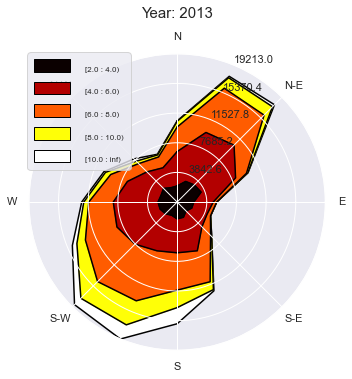

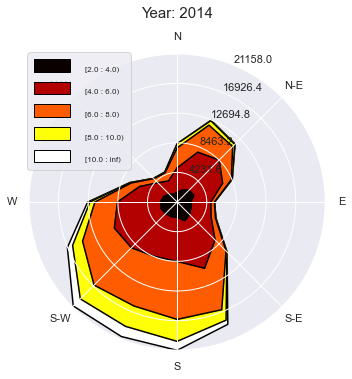

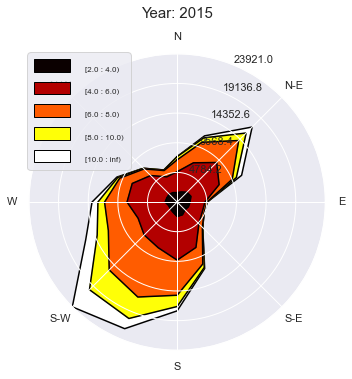

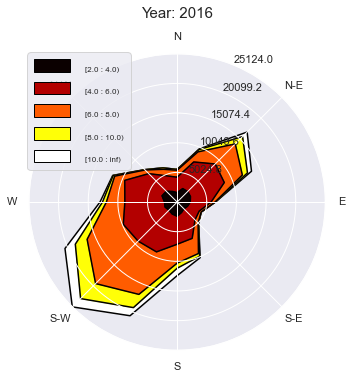

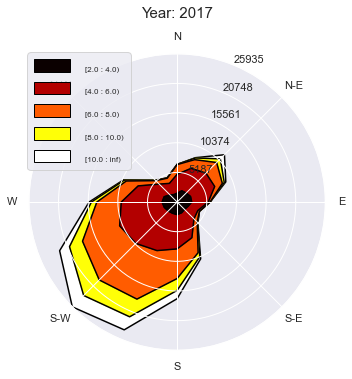

In [64]:
# Windrose plot with filled representation of wind speeds (frequency) and wind directions
# Yearly data 
list_years= [2013, 2014, 2015, 2016, 2017]
for y in list_years:
    year= y
    figure = plt.figure(figsize=(12,12))
    legend_position = 'upper left'
    ax = figure.add_subplot(221,projection='windrose')
    ax.contourf(df_4turb.loc[df_4turb['year']== year,'Wa_avg'], df_4turb.loc[df_4turb['year']==year,'Ws_avg'], 
                 bins = np.arange(2, 12, 2),cmap=cm.hot)
    ax.contour(df_4turb.loc[df_4turb['year']==year,'Wa_avg'], df_4turb.loc[df_4turb['year']==year,'Ws_avg'],
                colors='black',bins = np.arange(2, 12, 2))
    ax.set_legend(loc= legend_position, fontsize= 18)
    plt.title('Year:' +' '+ str(y), y=1.1, fontsize= 15)
    plt.show()

In [65]:
# Filter all months separatedly from the 5 years of records
jan= df_4turb[df_4turb['Jan']==1]
feb= df_4turb[df_4turb['Feb']==1]
mar= df_4turb[df_4turb['Mar']==1]
apr= df_4turb[df_4turb['Apr']==1]
may= df_4turb[df_4turb['May']==1]
jun= df_4turb[df_4turb['Jun']==1]
jul= df_4turb[df_4turb['Jul']==1]
aug= df_4turb[df_4turb['Aug']==1]
sept= df_4turb[df_4turb['Sept']==1]
octb = df_4turb[df_4turb['Oct']==1]
nov= df_4turb[df_4turb['Nov']==1]
dec= df_4turb[df_4turb['Dec']==1]

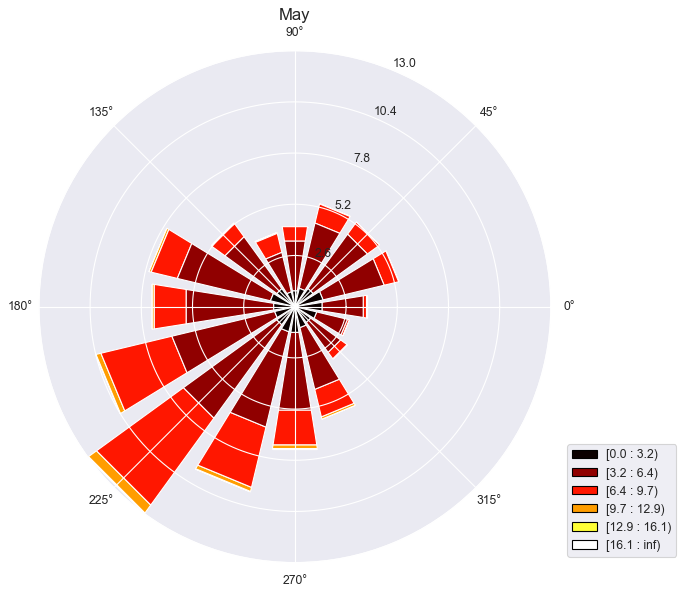

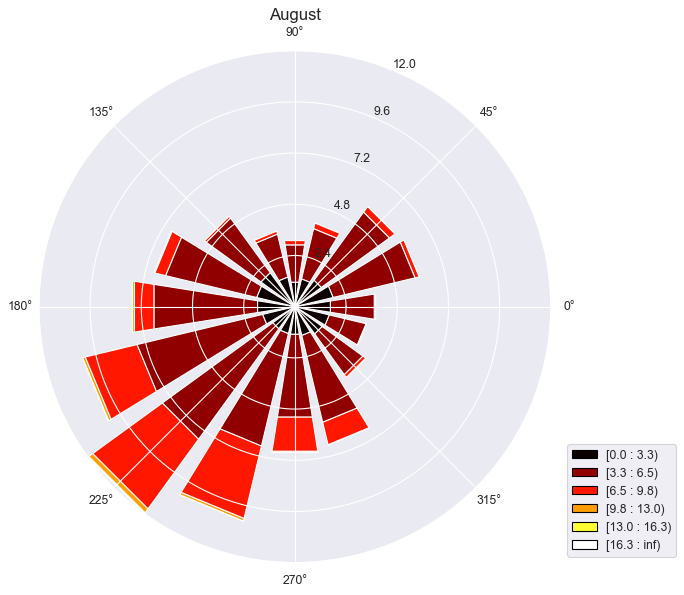

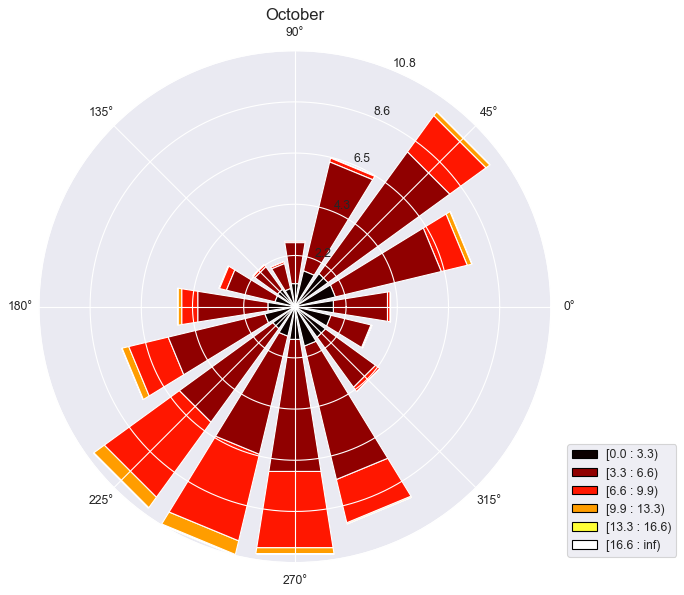

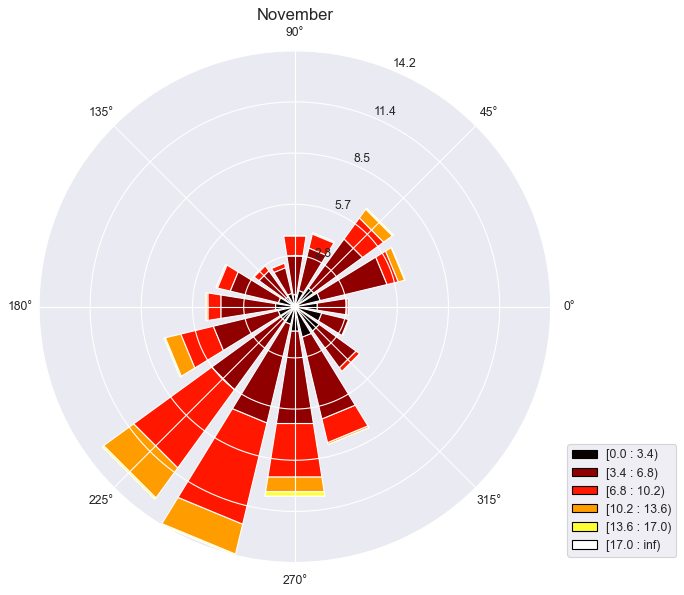

In [66]:
# Stacked histogram with wind directions and speeds
# Data separated by months from all the years that we have records
dfs_months = [jan, feb, mar, apr, may, jun, jul, aug, sept, octb, nov, dec]
labels =['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for i,j in zip(dfs_months,labels):

    ax = WindroseAxes.from_ax()
    ax.bar(i['Wa_avg'], i['Ws_avg'], normed=True, opening=0.8, edgecolor='white',cmap=cm.hot)
    ax.legend(bbox_to_anchor=(1.02, 0))
    ax.set_title((j), y=1, fontsize= 15)

In [67]:
# save some memory space
del [jan, feb, mar, apr, may, jun, jul, aug, sept, octb, nov, dec, df_4turb['year']]

### 8) Last processing before modelling <a class="anchor" id="s8"></a>

    - 8.1 Check for infinites and substitute
    - 8.2 Create dataframe from a single turbine
    - 8.3 Remove outliers with IQR
    - 8.4 Extract the target and save it as CSV
    - 8.5 Standarize
    - 8.6 NaN imputation: KNNimputer
    - 8.7 Export data for modelling as CSV

**8.1 Check for infinites and substitute** <a class="anchor" id="s8.1"></a>

In [68]:
# Substitute possible infinites (due to division by zero) for nan
df_4turb= df_4turb.replace(np.inf, np.nan)

**8.2 Create dataframe from a single turbine** <a class="anchor" id="s8.2"></a>

In [69]:
# Exctract a dataframe with a single generator
Turb11= df_4turb[df_4turb['Wind_turbine_name']=='R80711']

In [70]:
del Turb11['Wind_turbine_name']
del Turb11['Date_time']
del df_4turb['Wind_turbine_name']
del df_4turb['Date_time']

**8.3 Remove outliers with IQR** <a class="anchor" id="s8.3"></a>

In [71]:
# Data seems to be very homogeneous; if we settle Q1= 0.18 & Q3= 0.95 we loose more than 95% od data
Q1= df_4turb.quantile(0.05)
Q3= df_4turb.quantile(0.95)
IQR= Q3-Q1 # IQR is the first quartile subtracted from the third quartile

In [72]:
#Using IQR 
df_4turb = df_4turb[~((df_4turb < (Q1 - 1.5 * IQR)) |(df_4turb > (Q3 + 1.5 * IQR))).any(axis=1)]
df_4turb.shape

(999748, 96)

In [73]:
# IQR for a single turbine
Q1= Turb11.quantile(0.05)
Q3= Turb11.quantile(0.95)
IQR= Q3-Q1 
Turb11 = Turb11[~((Turb11 < (Q1 - 1.5 * IQR)) |(Turb11 > (Q3 + 1.5 * IQR))).any(axis=1)]
Turb11.shape

(249657, 96)

**8.4 Extract the target and save it as CSV** <a class="anchor" id="s8.4"></a>

- 4 Turbines:

In [ ]:
# Save copy of our target 
P_3h= df_4turb['P_3h']

In [ ]:
P_3h= pd.DataFrame(P_3h)

In [ ]:
P_3h.isnull().sum()

In [ ]:
P_3h.to_csv('P_3h.csv', index=True)

In [ ]:
del df_4turb['P_3h']

- 1 Turbine

In [ ]:
P_3h_Turb11= Turb11['P_3h']

In [ ]:
# Convert y to dataframe
P_3h_Turb11= pd.DataFrame(P_3h_Turb11)

In [ ]:
P_3h_Turb11.to_csv('P_3h_Turb11.csv', index=True)

In [ ]:
del Turb11['P_3h']

**8.5 Standarize** <a class="anchor" id="s8.5"></a>

- 4 Turbines:

In [ ]:
# Standarize
scaler = StandardScaler()
scaled = scaler.fit_transform(df_4turb)

In [ ]:
df= pd.DataFrame(scaled, columns=df_4turb.columns)

- 1 Turbine:

In [ ]:
# Standarize
scaler_turb11 = StandardScaler()
scaled_turb11 = scaler_turb11.fit_transform(Turb11)

In [ ]:
df_Turb11= pd.DataFrame(scaled_turb11, columns=Turb11.columns)

**8.6 NaN imputation: KNNimputer** <a class="anchor" id="s8.6"></a>

- 4 Turbines

In [ ]:
# KNNImputer for Nans
imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(df)

In [ ]:
df= pd.DataFrame(imputed, columns=df_4turb.columns)

- 1 Turbine

In [ ]:
# KNNImputer for Nans
imputer_turb11 = KNNImputer(n_neighbors=3)
imputed_turb11 = imputer_turb11.fit_transform(df_Turb11)

In [ ]:
df_Turb11= pd.DataFrame(imputed_turb11, columns=Turb11.columns)

**8.7 Export data for modelling as CSV** <a class="anchor" id="s8.7"></a>

In [ ]:
# CSV with 4 turbine's data
df.to_csv('4Gen_Model.csv', index=True)
# CSV with 1 turbine's data
df_Turb11.to_csv('Turb11_Model.csv', index=True)